In [1]:
# Titanic dataset can be found https://www.kaggle.com/c/titanic/data
# This is a very basic introduction to ML via Random forest classifers

# Get the libraries you will need - NOTE - They are case sensitive
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import scipy
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


In [2]:
#Now, we will read the data (my data is stored in a data folder in my wd)
#will read it directly into a dataframe

train = pd.read_csv(filepath_or_buffer='./data/train.csv')
test = pd.read_csv(filepath_or_buffer='./data/test.csv')

headers = train.columns
train.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#Looking at the data, there are some columns we can get rid of as they are not predictive
#Passengerid, ticket, name
# The axis specifies columns (0 would specify rows)
train = train.drop(['PassengerId', 'Ticket', 'Name'], axis=1)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [4]:
#Now, look at the columns to see which ones are fully filled and which are not
nullCols = pd.isnull(train).sum() > 0
nullCols

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
Cabin        True
Embarked     True
dtype: bool

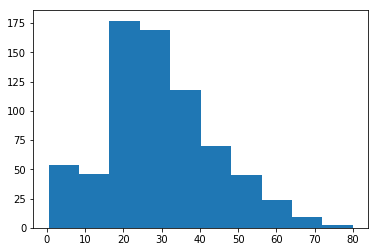

Mean Age: 29.69911764705882
Median Age: 28.0


In [5]:
# Now, think of suitable replacement values
# Age...

mean_age = np.mean(train['Age'].dropna())
median_age = np.median(train['Age'].dropna())

plt.hist(train['Age'].dropna())
plt.show()

print ('Mean Age: {}'.format(str(mean_age)))
print ('Median Age: {}'.format(str(median_age)))

In [6]:
# Could also look at the splits by gender
mean_split = train.groupby('Sex').mean()['Age']
mean_split



Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64

In [7]:
# Everything is pretty even, so I will just take 28 as the replacement value
train['Age'] = train['Age'].fillna(28)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [8]:
print (train.isnull().sum())
train.groupby('Embarked').count()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
Embarked,,,,,,,,
C,168,168,168,168,168,168,168,69
Q,77,77,77,77,77,77,77,4
S,644,644,644,644,644,644,644,129


In [9]:
#As we are only actually missing 2 values from embarked, we can just fill them in with our most common value
#You could also exclude them if you wanted
train['Embarked'] = train['Embarked'].fillna('S')
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [10]:
#Cabin looks a bit crazy, and we have a class, so we can also drop cabin
train = train.drop('Cabin', axis = 1)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [11]:
# Now we have decided on our null values and planned out the varaibles we are going to use, we need to onehotencode our data
# One hot encoding is a way of using categorical variables in models
# Our categoricals are:
# - Sex
# - Embarked
from sklearn.preprocessing import OneHotEncoder

# First, we need to take out our target variable
y = train['Survived']
train = train.drop('Survived', axis = 1)





In [12]:
#onehot_mask = [True if x.dtype != 'Float64' else False for x in train.dtypes]
#onehot_mask
train.dtypes
train['Sex'] = pd.Categorical(train['Sex'])
train['Embarked'] = pd.Categorical(train['Embarked'])

train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [13]:
# Get the dummy/onehot variables

train = pd.get_dummies(train, columns=['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'])

In [14]:
#Finally, we have to split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.2, random_state = 123)


print ('Train size: {}'.format(len(X_train.index)))
print ('Test size: {}'.format(len(X_test.index)))

Train size: 712
Test size: 179


In [15]:
# Now we can build the classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50
                            , criterion = 'gini'
                            , max_features = 'auto')

In [16]:
# Now we fit the classifier
clf = clf.fit(X=X_train, y=y_train)

In [17]:
scores = clf.score(X=X_test, y=y_test)
scores

0.82122905027932958

In [22]:
# An OK score...
# Lets look more closely at the results




KeyError: ('Pclass', 0)